# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3        #representation of visual information
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\prerana\Downloads\CP_2_PREX",
    seed=123,     # control over randomness in code, leading to more reliable, reproducible, and understandable results
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
len(dataset)

68

In [20]:
68*32 ## coz every element in the data is actually a batch of 32 images

2176

In [21]:
for image_batch, labels_batch in dataset.take(1): ## 1 batch is 32 images
    print(image_batch.shape)
    print(labels_batch.numpy()) 

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [22]:
## lets try t0 print 1st image 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


In [23]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

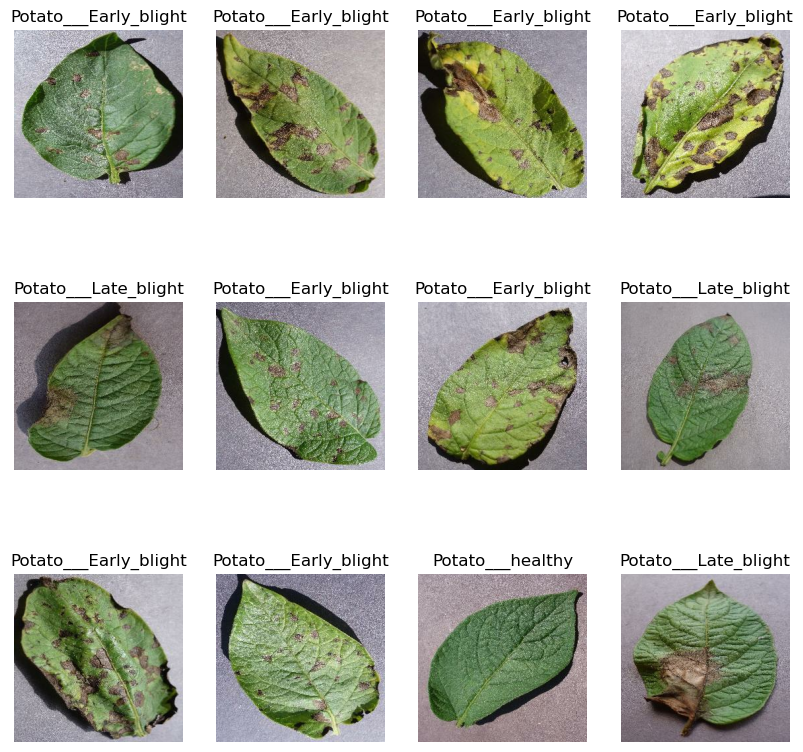

In [24]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) ## imshow-3d array, float converted to int 
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [11]:
## 80% is for training dataset
## 20% == here 10% is for validation & 10% is for test
## validation-- used during training process when we run each epoch, after each epoch we use this validation on this 10%

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8        ## coz 80% of training
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)  # skipping train
    test_ds = ds.skip(train_size).skip(val_size) # skipping val
    
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
len(train_ds)

54

In [29]:
len(val_ds)

6

In [30]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset
They contribute to faster convergence, better generalization, and overall improved performance of machine learning models.

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
## inference: my dataset is kind of optimized so model learns efficiently

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [39]:
## means that each pixel value in the input image will be divided by 255.
## rescaling step is useful because it brings all pixel values into a standardized range between 0 and 1

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [42]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
## creating multiple images from single image

#### Applying Data Augmentation to Train Dataset

In [44]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #convolutional layer with 32 filters.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), #Max pooling reduces the spatial dimensions of the input feature maps by taking the maximum value from each 2x2 region.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [47]:
# convolutional layer with 32 filters.
# Max pooling reduces the spatial dimensions of the input feature maps by taking the maximum value from each 2x2 region.

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [31]:
## inference
#  total params= total no. of trainable parameters
#  Trainable params= number of parameters that will be updated during training
#  Non-trainable params= parameters that are not updated during training

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [33]:
model.compile(         
    optimizer='adam',  #adjusts the learning rate during training.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #This specifies the loss function used during training.
    metrics=['accuracy'] # track the traing process
)

In [49]:
## from_logits=False specifies that the model's output is probabilities rather than logits

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, ## how much info you want or detail you want to see
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 57s 942ms/step - loss: 0.9132 - accuracy: 0.4936 - val_loss: 0.8273 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 51s 923ms/step - loss: 0.6922 - accuracy: 0.6788 - val_loss: 0.5729 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 49s 900ms/step - loss: 0.4964 - accuracy: 0.7789 - val_loss: 0.2226 - val_accuracy: 0.9323
Epoch 4/50
54/54 [==============================] - 47s 867ms/step - loss: 0.3942 - accuracy: 0.8275 - val_loss: 0.2378 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 47s 864ms/step - loss: 0.2804 - accuracy: 0.8796 - val_loss: 0.1459 - val_accuracy: 0.9427
Epoch 6/50
54/54 [==============================] - 48s 882ms/step - loss: 0.1634 - accuracy: 0.9416 - val_loss: 0.2609 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 48s 882ms/step - loss: 0.1625 - accuracy: 0.9358 - val_loss: 0.1189 - val_accuracy: 0.95

In [35]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 223ms/step - loss: 0.0091 - accuracy: 0.9961


**You can see above that we get 99.61% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [36]:
scores

[0.009069530293345451, 0.99609375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [37]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

50

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9132182598114014,
 0.6921897530555725,
 0.4963589012622833,
 0.39418619871139526,
 0.28040555119514465]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

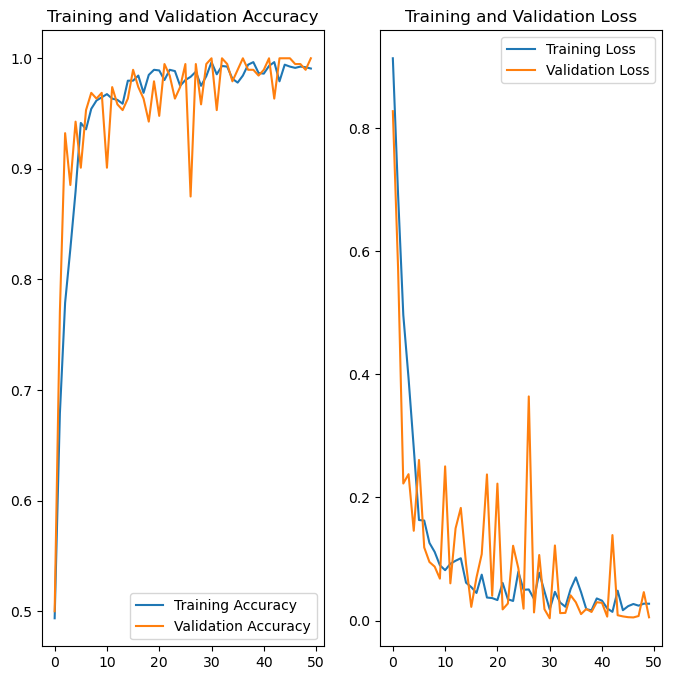

In [44]:
## training vs accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

## traing vs validation loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
## loss is basically an error in backpropagation keeps on reducing as we proceed in our epoch

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 267ms/step
predicted label: Potato___Early_blight


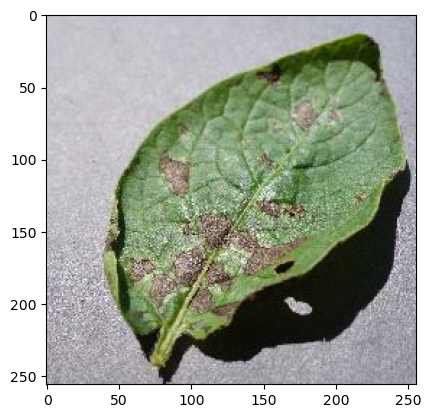

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) #retrieves the class name corresponding to the predicted label.

### Write a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2) 
    return predicted_class, confidence

In [54]:
# np.argmax: calculates the index of the class with the highest predicted probability from the array of predicted probabilities.
# np.max: calculates the maximum predicted probability from the array of predicted probabilities.
# modle prediction n decision making

**Now run inference on few sample images**

1/1 [==============================] - 0s 12ms/step


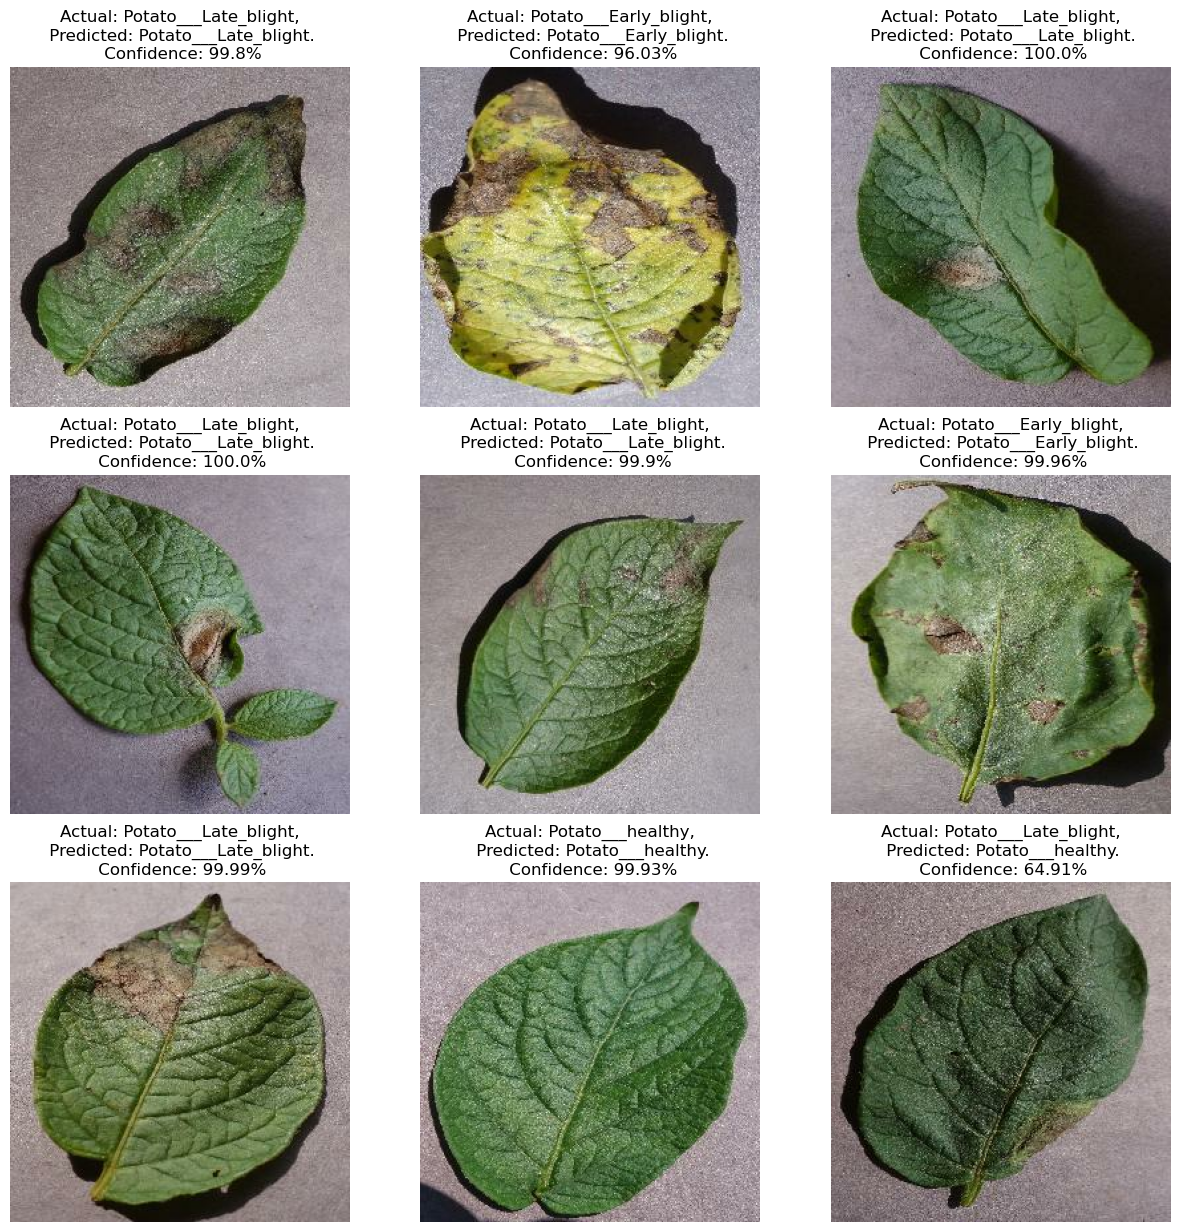

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [56]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{C:\Users\prerana\Downloads\CP_2_PREX}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: truncated \UXXXXXXXX escape (2392500844.py, line 3)

In [57]:
model.save("../potatoes.h5")

C:\Users\prerana\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionError: [Errno 13] Unable to create file (unable to open file: name = '../potatoes.h5', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)